<a href="https://colab.research.google.com/github/ozcannrabia/feature-engineering/blob/main/missing_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# gözlemlerde eksik değerlerin olması durumu
# eksik değer işlemleri ;
# 1 -> silme
# 2 -> değer atama
# 3 -> tahmine dayalı

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [ ]:
def load():
  df = pd.read_csv("titanic.csv")
  return df
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# eksik değer var mı
df.isnull().values.any()
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
# yüzdelik olarak eksik değer oranı

,0
Cabin,77.104377
Age,19.865320
Embarked,0.224467
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
SibSp,0.000000
Parch,0.000000


In [ ]:
na_cols = [col for col in df.columns if df[col].isnull().sum()>0]
na_cols
# sadece eksik değer olan sütun isimleri

['Age', 'Cabin', 'Embarked']

In [ ]:
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")
  if na_name:
    return na_columns
missing_values_table(df)
# eksik değer sayıları ve oranları gösterilir

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


Eksik Değer Çözme

Silme

In [ ]:
df.dropna().shape

(183, 12)

Atama

In [ ]:
df["Age"].fillna(df["Age"].mean()).isnull().sum()

0

In [ ]:
dff = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0).head()
# sayısal değişkenlerdeki eksik değerleri mean ile doldurduk

In [ ]:
dff.isnull().sum().sort_values(ascending=False)

,0
Cabin,3
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0


In [ ]:
df["Embarked"].fillna(df["Embarked"].mode()[0]).isnull().sum()

0

In [ ]:
df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Kategorik Değişken Kırılımında Değer Atama

In [ ]:
df.groupby("Sex")["Age"].mean()

,Age
Sex,
female,27.915709
male,30.726645


In [ ]:
df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean")).isnull().sum()
# transform kırılıma göre istenilen yerlere doldurma yapar

0

Tahmine Dayalı Atama

In [ ]:
df = load()

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [ ]:
num_cols = [col for col in num_cols if col not in "PassengerId"]

In [ ]:
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first = True, dtype=int)
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,1,0,22.0,7.2500,1,0,1
1,1,1,1,0,38.0,71.2833,0,0,0
2,1,3,0,0,26.0,7.9250,0,0,1
3,1,1,1,0,35.0,53.1000,0,0,1
4,0,3,0,0,35.0,8.0500,1,0,1


In [ ]:
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()
# standartlaştırdık

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.0,1.0,0.125,0.0,0.271174,0.014151,1.0,0.0,1.0
1,1.0,0.0,0.125,0.0,0.472229,0.139136,0.0,0.0,0.0
2,1.0,1.0,0.000,0.0,0.321438,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.125,0.0,0.434531,0.103644,0.0,0.0,1.0
4,0.0,1.0,0.000,0.0,0.434531,0.015713,1.0,0.0,1.0


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()
# en yakın değerlerin ortalamasıyla doldurduk

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.0,1.0,0.125,0.0,0.271174,0.014151,1.0,0.0,1.0
1,1.0,0.0,0.125,0.0,0.472229,0.139136,0.0,0.0,0.0
2,1.0,1.0,0.000,0.0,0.321438,0.015469,0.0,0.0,1.0
3,1.0,0.0,0.125,0.0,0.434531,0.103644,0.0,0.0,1.0
4,0.0,1.0,0.000,0.0,0.434531,0.015713,1.0,0.0,1.0


In [ ]:
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [ ]:
df["age_imputed_knn"] = dff[["Age"]]
df.loc[df["Age"].isnull(), ["Age", "age_imputed_knn"]]

,Age,age_imputed_knn
5,NaN,47.8
17,NaN,37.6
19,NaN,12.2
26,NaN,32.8
28,NaN,17.6
...,...,...
859,NaN,25.8
863,NaN,8.8
868,NaN,25.0
878,NaN,24.4


Gelişmiş Analizler

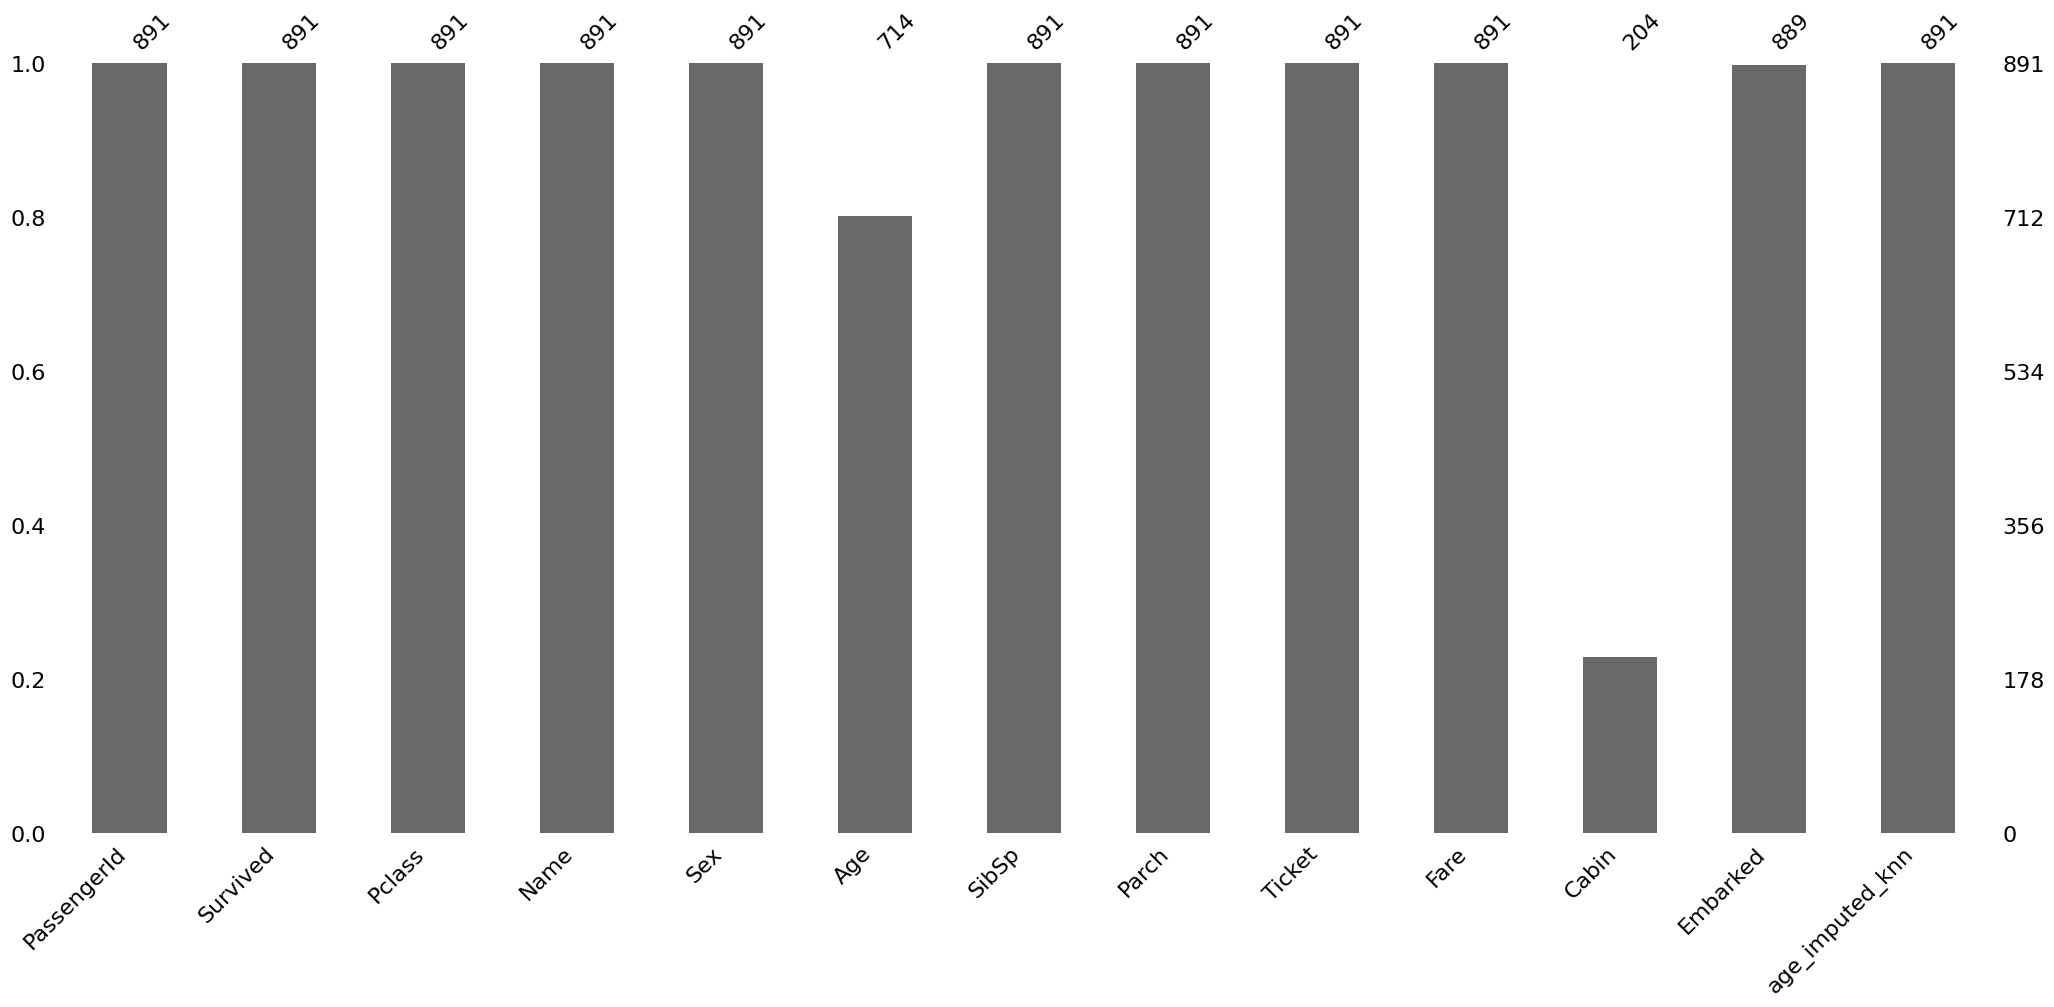

In [ ]:
msno.bar(df)
plt.show()

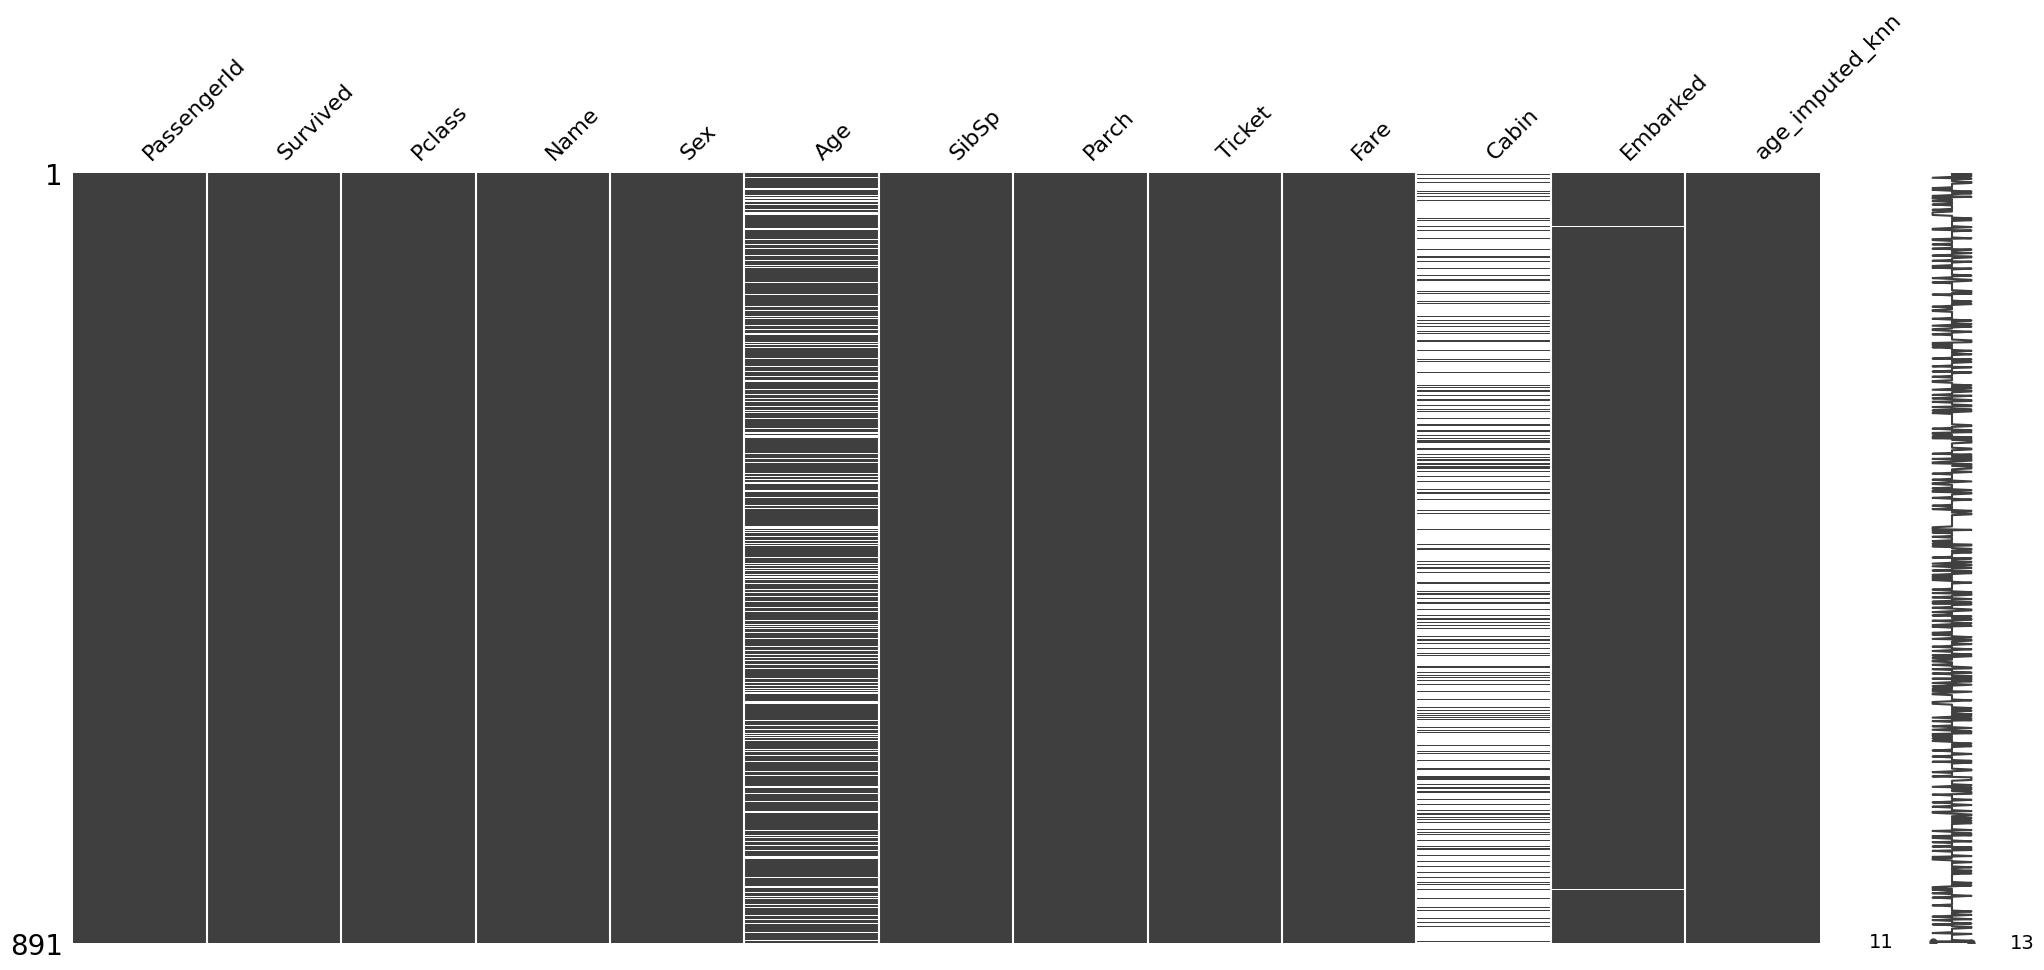

In [ ]:
msno.matrix(df)
plt.show()

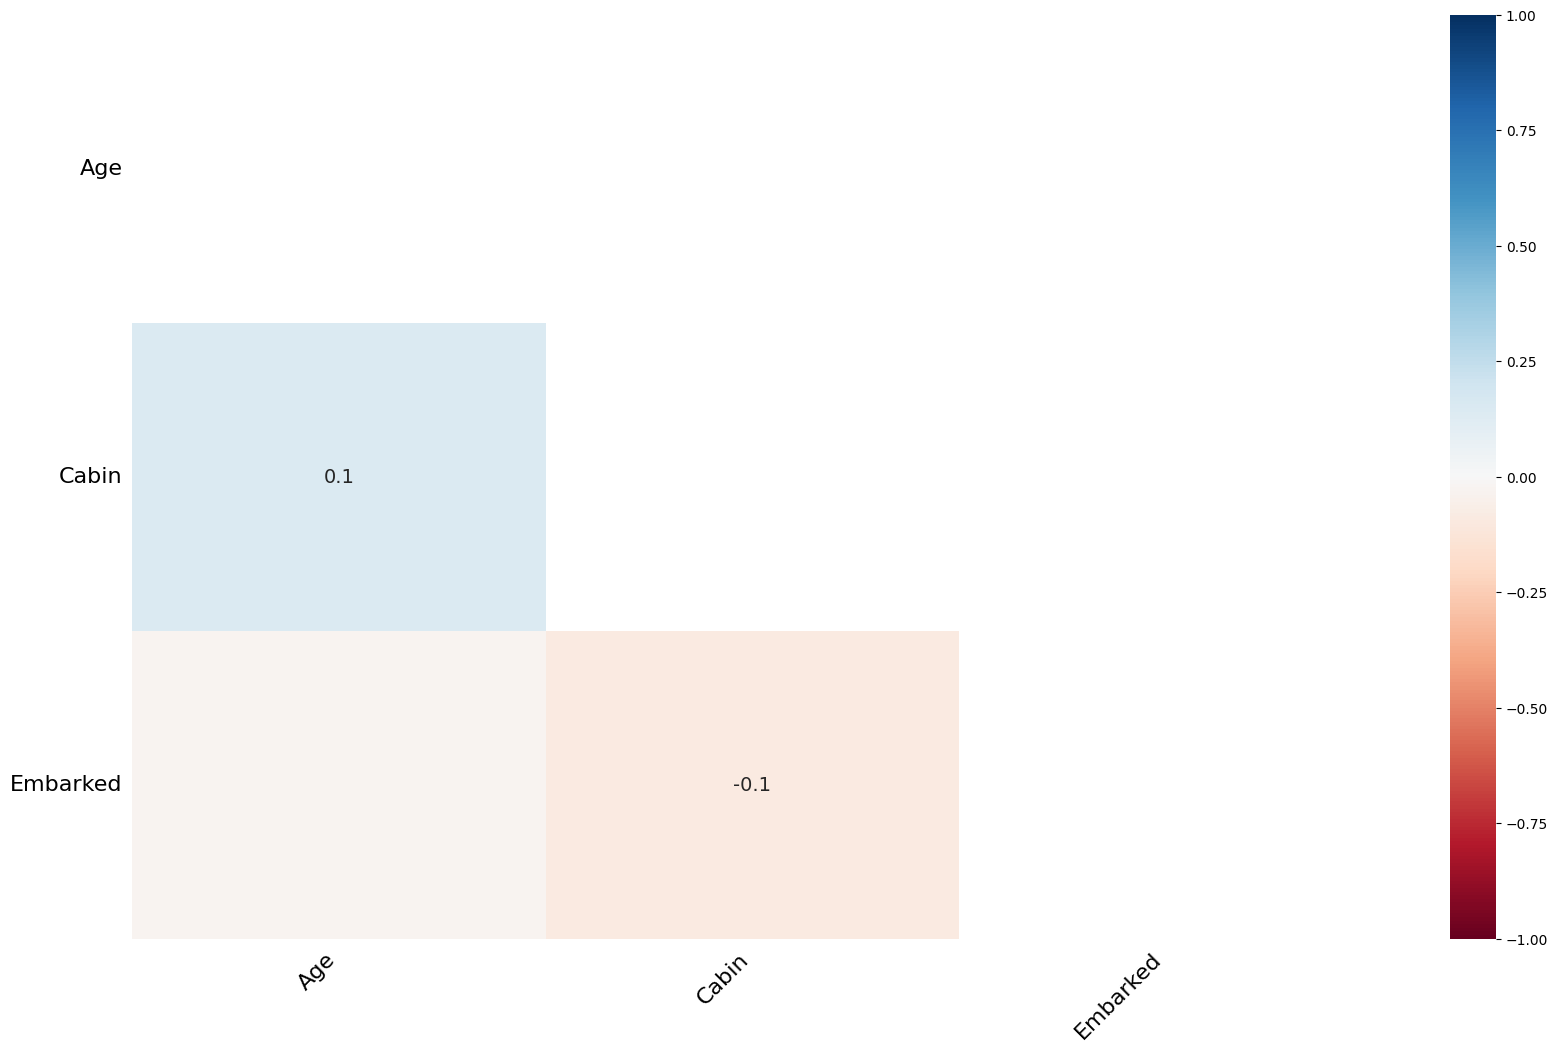

In [ ]:
msno.heatmap(df)
plt.show()
# eksiklikler birbiriyle anlamsız

Eksik Değerlerin Bağımlı Değişken İle İlişkisi

In [ ]:
na_cols = missing_values_table(df, True)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


In [ ]:
def missing_vs_target(dataframe, target, na_columns):
  temp_df = dataframe.copy()
  for col in na_columns:
    temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
  na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
  for col in na_flags:
    print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                        "count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

missing_vs_target(df, "Survived", na_cols)

             TARGET_MEAN  count
Age_NA_FLAG                    
0               0.406162    714
1               0.293785    177


               TARGET_MEAN  count
Cabin_NA_FLAG                    
0                 0.666667    204
1                 0.299854    687


                  TARGET_MEAN  count
Embarked_NA_FLAG                    
0                    0.382452    889
1                    1.000000      2




Tekrar

In [ ]:
df = load()
na_cols = missing_values_table(df, True)
# sayısal değişkenleri median ile doldurma
df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0).isnull().sum()
# kategorik değişkenleri mod ile doldurma
df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()
# kategorik değişken kırılımında sayısal değişkenleri doldurma
df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean")).isnull().sum()
# tahmine dayalı atama ile doldurma
missing_vs_target(df, "Survived", na_cols)